In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Eval Function

In [4]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [5]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## Data

In [6]:
# 2. Đọc file csv
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,10760,10790,10760,10790,2410,IMP
1,1,2014-01-03,10760,10840,10670,10840,13010,IMP
2,2,2014-01-06,10870,11560,10870,11540,55630,IMP
3,3,2014-01-07,11400,11540,11330,11540,20980,IMP
4,4,2014-01-08,11370,11830,11330,11800,43410,IMP
...,...,...,...,...,...,...,...,...
2462,2462,2023-12-04,54700,55500,54400,55300,24800,IMP
2463,2463,2023-12-05,55200,55200,54600,55000,10200,IMP
2464,2464,2023-12-06,55000,55200,54900,55200,26600,IMP
2465,2465,2023-12-07,54900,55900,54900,55200,29200,IMP


### Choose X

## Train, test, valid

In [7]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 6:3:1
df = pd.read_csv(company_csv)
df = df[['close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets 6:3:1
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [8]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['close'])

## Build model

### Choose p, q, d

In [9]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= data[['high','open','low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=34556.686, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=22488.572, Time=0.67 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=22508.652, Time=2.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=22490.485, Time=2.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=4.93 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=22488.841, Time=2.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=22488.402, Time=3.57 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28755.593, Time=4.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=22494.259, Time=2.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=22490.304, Time=5.84 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=30678.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1480
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -11240.201
Date:                Sat, 16 Dec 2023   AIC                          22488.402
Time:                        15:54:17   BIC                          22509.602
Sample:                             0   HQIC                         22496.305
                               - 1480                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.9426     27.192      0.770      0.441     -32.352      74.237
ar.L1          0.9992      0.001    885.833      0.000       0.997       1.001
ma.L1         -0.1126      0.016     -7.110      0.000      -0.144      -0.082
sigma2      2.304e+05   4913.403     46.886      0.000    2.21e+05     2.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1013.26
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [10]:
model = ARIMA(y_train, order=(1,0,1),exog=data[['high','open','low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1480
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10290.732
Date:                Sat, 16 Dec 2023   AIC                          20595.465
Time:                        15:54:22   BIC                          20632.563
Sample:                             0   HQIC                         20609.295
                               - 1480                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.0439     48.236      1.017      0.309     -45.496     143.584
high           0.7904      0.011     71.997      0.000       0.769       0.812
open          -0.3921      0.014    -28.945      0.000      -0.419      -0.366
low            0.5993      0.012     51.384      0.000       0.576       0.622
ar.L1          0.9239      0.035     26.398      0.000       0.855       0.993
ma.L1         -0.8742      0.045    -19.636      0.000      -0.961      -0.787
sigma2       6.51e+04   1564.314     41.616      0.000     6.2e+04    6.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.01   Jarque-Bera (JB):              1033.64
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=data[['high','open','low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=data[['high','open','low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [12]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  386.8740872621824
MAPE:  0.7239404326686487
RMSE:  566.1480102048075

** Validate **
MAE:  412.975123704273
MAPE:  0.7315442035634578
RMSE:  568.4218972529795


## Forecast

In [13]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# exogg = data[['high','open','low']][last_index-447:last_index].values.reshape(1341, 0)
# 1332 - 444 ; 1341 - 447; 1338 - 446
y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog= data[['high','open','low']][last_index-1017:last_index])
#data[['high','open','low']][last_index-447:last_index]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
2467    57312.196218
2468    57426.311868
2469    56593.431734
2470    56698.945351
2471    58889.888849
2472    59064.588610
2473    59162.748927
2474    58007.035784
2475    57611.822066
2476    57727.497510
2477    57625.204951
2478    56567.609472
2479    56254.643393
2480    57239.199222
2481    55815.122287
2482    56430.919109
2483    55716.329521
2484    55456.878820
2485    55196.795671
2486    56124.926123
2487    55476.628842
2488    55709.624832
2489    53654.991490
2490    54615.396652
2491    55311.206218
2492    54618.939099
2493    55071.843091
2494    54758.539461
2495    55016.725265
2496    55609.229618
Name: predicted_mean, dtype: float64


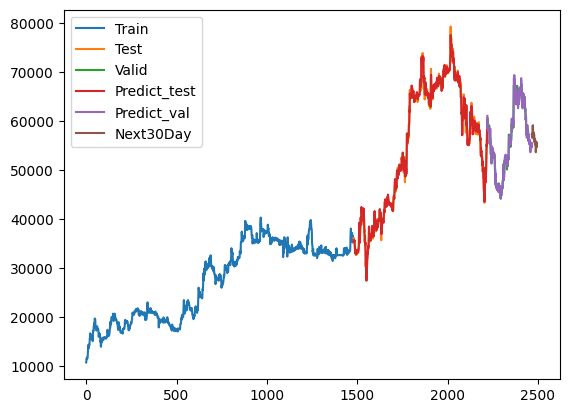

In [14]:
plt.plot(train_data.index, train_data['close'])
plt.plot(test_data.index, test_data['close'])
plt.plot(val_data.index, val_data['close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()